In [128]:
!pip install folium

You should consider upgrading via the 'c:\users\csh51\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

In [3]:
#플롯에서 한글이 깨지는 경우가 없도록 폰트 지정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [64]:
scaler = MinMaxScaler()

df = pd.read_csv('청년인프라지수.csv', encoding='cp949')

df = df.drop('Unnamed: 0',axis=1)
df.set_index('시군구', inplace=True)

df

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
시군구,,,,,,,,,,,,,,,,,
서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,2.347790
서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,2.099419
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,4.376027
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.852870
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.450149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,3.561763
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,3.604014
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,5.094272


In [65]:
df_loc = pd.read_csv('시군구_위경도.csv', encoding='cp949')
df_loc = df_loc.drop(['Unnamed: 4'], axis = 1) #비어있는 열 제거 

df_loc = df_loc.loc[0:74] #세종까지 행을 자름
df_loc = df_loc.set_index('name') # 인덱스를 시군구로 지정

#위경도를 붙어줌
df_loc_merge = df.join(df_loc, how='left')
df_loc_merge.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,2.347790,11110.0,37.594920,126.977317
서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,2.099419,11140.0,37.560143,126.995968
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,4.376027,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.852870,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.450149,11215.0,37.546722,127.085746


## 이상치 데이터 처리

### 1) IQR 방식을 이용한 이상치 제거

In [66]:
def get_outlier(df, column, weight=1.5):
    # 이상치가 있는 index 반환
    
    # 1/4분위와 3/4분위 지점 지정
    quantile_25 = np.percentile(df[column].values, 25) #Q1
    quantile_75 = np.percentile(df[column].values, 75) #Q3
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고, index 반환
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx

In [67]:
# 이상치 제거 필요 변수
# => 병원, 사회스포츠, 경찰서, 소형상업시설, 대형상업시설


# 이상치가 있지만 제거 x
# => 초중고, 숙박시설, 행정기관, 문화시설
# '초중고'는 굳이 제거하지 않아도 된다고 생각하여 이상치 제거 x.

In [68]:
outlier_idx1 = get_outlier(df_loc_merge, '병원')
print("이상치 데이터 index1: ", outlier_idx1)

outlier_idx2 = get_outlier(df_loc_merge, '사회스포츠')
print("이상치 데이터 index2: ", outlier_idx2)

outlier_idx3 = get_outlier(df_loc_merge, '경찰서')
print("이상치 데이터 index3: ", outlier_idx3)

outlier_idx4 = get_outlier(df_loc_merge, '소형상업시설(음식점_카페_학원_편의점)')
print("이상치 데이터 index4: ", outlier_idx4)

outlier_idx5 = get_outlier(df_loc_merge, '대형상업시설')
print("이상치 데이터 index5: ", outlier_idx5)

이상치 데이터 index1:  Index(['서울_서초구', '서울_강남구', '서울_송파구'], dtype='object', name='시군구')
이상치 데이터 index2:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index3:  Index(['서울_종로구'], dtype='object', name='시군구')
이상치 데이터 index4:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index5:  Index(['서울_중구'], dtype='object', name='시군구')


In [69]:
df_copy = df_loc_merge.copy()

df_copy.drop(outlier_idx1, axis=0, inplace=True)
df_copy.drop(outlier_idx3, axis=0, inplace=True)
df_copy.drop(outlier_idx5, axis=0, inplace=True)

In [70]:
df_copy

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,4.376027,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.852870,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.450149,11215.0,37.546722,127.085746
서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,6.319938,11230.0,37.581957,127.054848
서울_중랑구,83722.0,539,96.0,1,76.0,0,1,9,4410,14,89,7,18.0,0.0,5.0,1.0,7.320742,11260.0,37.597819,127.092884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,3.561763,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,3.604014,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,5.094272,31200.0,35.610062,129.379802


In [71]:
df_col = df_copy[['청년인프라지수','lat','lon']] #정규화 진행전 빼놓기
df_copy = df_copy.drop(['청년인프라지수','id','lat','lon'], axis=1)

#정규화 진행
df_copy[:] = scaler.fit_transform(df_copy[:])
df_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널
시군구,,,,,,,,,,,,,,,,
서울_용산구,0.318906,0.335253,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.498214,0.403509,0.275316,1.000000,0.478261,0.25,0.618421,0.00
서울_성동구,0.414634,0.494240,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.441282,0.385965,0.142405,0.333333,0.521739,0.00,0.394737,0.00
서울_광진구,0.569801,0.610599,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.561945,0.456140,0.155063,0.000000,0.434783,0.00,0.315789,0.25
서울_동대문구,0.498842,0.655530,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.480466,0.578947,0.300633,0.777778,0.391304,0.00,0.263158,0.00
서울_중랑구,0.521641,0.588710,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.423764,0.245614,0.227848,0.777778,0.478261,0.00,0.052632,0.25


In [72]:
#회귀분석에서 병원, 경찰서, 소형상업, 숙박시설, 법원_교도소이 유의미한 영향이 있다고 확인
df_copy['intercept'] = 1
lm = sm.OLS(df_copy['청년인구'], df_copy[['병원','경찰서','소형상업시설(음식점_카페_학원_편의점)','숙박시설','법원, 교도소']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   청년인구   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              308.4
Date:                Tue, 24 Aug 2021   Prob (F-statistic):                    7.33e-44
Time:                        15:18:07   Log-Likelihood:                          72.197
No. Observations:                  70   AIC:                                     -134.4
Df Residuals:                      65   BIC:                                     -123.2
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
병원                        0.4469      0.087      5.159      0.000       0.274       0.620
경찰서                       0.1813      0.057      3.163      0.002       0.067       0.296
소형상업시설(음식점_카페_학원_편의점)     0.2865      0.099      2.880      0.005       0.088       0.485
숙박시설                     -0.1545      0.049     -3.154      0.002      -0.252      -0.057
법원, 교도소                  -0.1235      0.049     -2.508      0.015      -0.222      -0.025
==============================================================================
Omnibus:                       28.798   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.203
Skew:                           1.131   Prob(JB):                     1.29e-21
Kurtosis:                       8.279   Cond. No.                         11.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(lm.exog, i)} 
             for i, column in enumerate(lm.exog_names)
                 if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,병원,19.232110
1,경찰서,6.984519
2,소형상업시설(음식점_카페_학원_편의점),24.466710
3,숙박시설,2.516361
4,"법원, 교도소",1.587701


In [74]:
lm = sm.OLS(df_copy['청년인구'], df_copy[['병원','경찰서','숙박시설','법원, 교도소']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   청년인구   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              345.3
Date:                Tue, 24 Aug 2021   Prob (F-statistic):                    1.81e-43
Time:                        15:18:08   Log-Likelihood:                          67.994
No. Observations:                  70   AIC:                                     -128.0
Df Residuals:                      66   BIC:                                     -119.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
병원             0.6574      0.049     13.401      0.000       0.559       0.755
경찰서            0.2185      0.059      3.712      0.000       0.101       0.336
숙박시설          -0.1085      0.049     -2.223      0.030      -0.206      -0.011
법원, 교도소       -0.0788      0.049     -1.600      0.114      -0.177       0.020
==============================================================================
Omnibus:                       21.977   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.574
Skew:                           0.905   Prob(JB):                     3.15e-13
Kurtosis:                       7.058   Cond. No.                         5.14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(lm.exog, i)} 
             for i, column in enumerate(lm.exog_names)
                 if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

#소형상업시설과 병원의 상관관게가 너무 높아 소형상업시설은 빼고 군집분석 실시

,컬럼,VIF
0,병원,5.552166
1,경찰서,6.630654
2,숙박시설,2.248952
3,"법원, 교도소",1.429882


In [76]:
#정규화 후 위경도,인프라지수 합쳐주기
df_copy = df_copy.drop('intercept', axis = 1)
df_copy = df_copy.join(df_col, how = 'left')
df_copy

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,lat,lon
시군구,,,,,,,,,,,,,,,,,,,
서울_용산구,0.318906,0.335253,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.498214,0.403509,0.275316,1.000000,0.478261,0.25,0.618421,0.00,4.376027,37.531386,126.979908
서울_성동구,0.414634,0.494240,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.441282,0.385965,0.142405,0.333333,0.521739,0.00,0.394737,0.00,5.852870,37.551030,127.041059
서울_광진구,0.569801,0.610599,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.561945,0.456140,0.155063,0.000000,0.434783,0.00,0.315789,0.25,6.450149,37.546722,127.085746
서울_동대문구,0.498842,0.655530,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.480466,0.578947,0.300633,0.777778,0.391304,0.00,0.263158,0.00,6.319938,37.581957,127.054848
서울_중랑구,0.521641,0.588710,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.423764,0.245614,0.227848,0.777778,0.478261,0.00,0.052632,0.25,7.320742,37.597819,127.092884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,0.397716,0.679724,0.047368,0.166667,0.516854,0.0,0.5,0.250000,0.775268,0.280702,0.718354,0.444444,0.391304,0.50,0.223684,0.75,3.561763,35.516052,129.328190
울산_동구,0.148005,0.168203,0.015789,0.166667,0.258427,0.0,0.5,0.166667,0.273597,0.052632,0.170886,0.000000,0.130435,0.00,0.039474,0.00,3.604014,35.525580,129.426070
울산_북구,0.246712,0.165899,0.078947,0.000000,0.449438,1.0,0.5,0.166667,0.317967,0.192982,0.110759,0.222222,0.086957,0.00,0.105263,0.00,5.094272,35.610062,129.379802


## 클러스터 결정

C:\Users\csh51\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


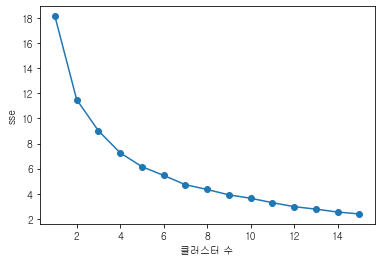

In [78]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

x = df_copy[['청년인구','병원','경찰서','숙박시설','법원, 교도소']].values

## 방법 elbow기법

from sklearn.cluster import KMeans
init_centroid = "random" # 초기 클러스터 중심을 임의적
#init_centroid = "k-means++" # 기본값

def elbow(x):
    sse = [] #오차제곱합이 최소가 되도록 클러스터의 중심을 결정
    for i in range(1, 16):
        km = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(1, 16), sse, marker = "o")
    plt.xlabel("클러스터 수")
    plt.ylabel("sse")
    plt.show()
    
elbow(x)

# k=3,4,5로실시

## K-means

### K = 3

#x[0] : 청년인구
#x[1] : 병원
#x[2] : 경찰서
#x[3] : 숙박시설
#x[4] : 법원, 교도소

from sklearn.cluster import KMeans
init_centroid = "random" # 초기 클러스터 중심을 임의적
#init_centroid = "k-means++" # 기본값

kmodel = KMeans(n_clusters = 3, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['초중고,대학,소형상업시설의 수가 높다','평균','모든 인프라가 다른곳에 비해 떨어짐'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소']
center

import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if pred[i]==0:
        point = 'red'
    elif pred[i]== 1:
        point='blue'
    elif pred[i]== 2:
        point='darkblue'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = df_copy.index[i],
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

### K = 4

In [115]:
kmodel = KMeans(n_clusters = 4, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['관광도시','아파트 단지, 산업단지가 많은 곳','대부분의 서울지역, 발전된 도시(유동인구가 많은곳) ','낙후된 도시'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소']

mean_1 = df_copy[pred == 0]['청년인프라지수'].mean()
mean_2 = df_copy[pred == 1]['청년인프라지수'].mean()
mean_3 = df_copy[pred == 2]['청년인프라지수'].mean()
mean_4 = df_copy[pred == 3]['청년인프라지수'].mean()

center['청년인프라지수'] = mean_1,mean_2,mean_3,mean_4

center


KMeans(init='random', n_clusters=4, random_state=0)
pred:  [1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 3 2 2 2 2 3 3 3 3 2 3 3 3 0 3 3 1 1 3 3 3 3
 2 3 3 2 1 1 1 0 3 1 3 2 2 3 2 0 0 1 1 3 1 2 3 3 1 1 3 3 1 3 3 0 1]


,청년인구,병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
관광도시,0.167076,0.223272,0.550000,0.846835,0.150000,2.955343
"아파트 단지, 산업단지가 많은 곳",0.396128,0.529800,0.511111,0.272785,0.516667,4.400169
"대부분의 서울지역, 발전된 도시(유동인구가 많은곳)",0.575058,0.693164,0.600694,0.225475,0.031250,6.123076
낙후된 도시,0.214307,0.296836,0.233974,0.212390,0.009615,4.226920


In [127]:
import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if pred[i]==0: #관광도시
        point = 'red'
    elif pred[i]== 1:
        point='blue'
    elif pred[i]== 2:
        point='darkblue'
    elif pred[i]== 3:
        point='lightgreen'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = (df_copy.index[i],
                               center.index[pred[i]], 
                               df_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map



In [ ]:
#Map.save('K-means군집분석 지도.html')

### K = 5

kmodel = KMeans(n_clusters = 5, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['그 지역에서 완전 발전된 도시(모든 인프라가 집중)','관광도시','??','발전되지 못한 지역','서울+광역시 내에서 발전된 지역'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소']
center

import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if pred[i]==0:
        point = 'red'
    elif pred[i]== 1:
        point='blue'
    elif pred[i]== 2:
        point='darkblue'
    elif pred[i]== 3:
        point='lightgreen'
    elif pred[i]== 4:
        point='purple'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = df_copy.index[i],
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

## 계층적 군집분석

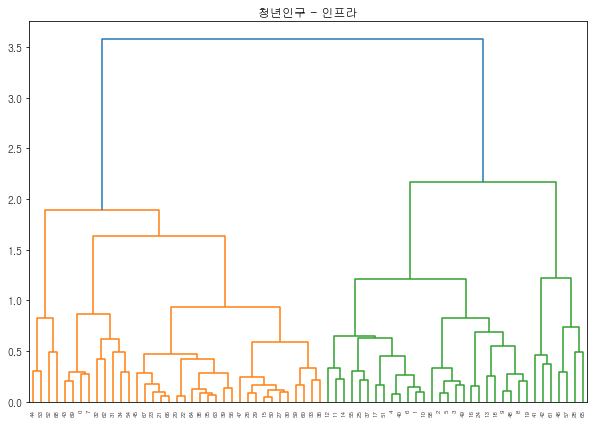

In [117]:
from scipy.cluster.hierarchy import dendrogram, linkage #계층적 군집분석시 필요
from matplotlib import pyplot as plt

df_Den = df_copy.reindex(columns=['청년인구','병원','경찰서','숙박시설','법원, 교도소'])

linked = linkage(df_Den, 'single')

labelList = df_copy.index


import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("청년인구 - 인프라")
dend = shc.dendrogram(shc.linkage(df_Den, method='ward'))

### K = 3

#군집분석 결과
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()


center = pd.DataFrame([arr1,arr2,arr3],
                     index = ['군집1', '군집2', '군집3'])
center

import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if df_pred[i]==0:
        point = 'red'
    elif df_pred[i]== 1:
        point='blue'
    elif df_pred[i]== 2:
        point='darkblue'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = df_copy.index[i],
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

### K = 4

In [122]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()

center = pd.DataFrame([arr1,arr2,arr3,arr4],
                     index = ['낙후된지역','아파트 단지, 산업단지가 많은 곳','대부분의 서울지역, 발전된 도시(유동인구가 많은곳) ','관광도시'])

mean_1 = df_copy[df_pred == 0]['청년인프라지수'].mean()
mean_2 = df_copy[df_pred == 1]['청년인프라지수'].mean()
mean_3 = df_copy[df_pred == 2]['청년인프라지수'].mean()
mean_4 = df_copy[df_pred == 3]['청년인프라지수'].mean()

center['청년인프라지수'] = mean_1,mean_2,mean_3,mean_4

center



,청년인구,병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
낙후된지역,0.230893,0.299050,0.287879,0.199942,0.106061,4.276384
"아파트 단지, 산업단지가 많은 곳",0.523184,0.770244,0.583333,0.462025,0.642857,4.413811
"대부분의 서울지역, 발전된 도시(유동인구가 많은곳)",0.555978,0.683490,0.583333,0.237220,0.038462,5.948057
관광도시,0.103376,0.096486,0.541667,0.814873,0.125000,2.741542


In [126]:
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if df_pred[i]==0:
        point = 'lightgreen'
    elif df_pred[i]== 1:
        point='blue'
    elif df_pred[i]== 2:
        point='darkblue'
    elif df_pred[i]== 3:
        point='red'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = (df_copy.index[i],
                               center.index[df_pred[i]], 
                               df_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map



In [ ]:
#Map.save('계층적 군집분석 지도.html')

### K = 5

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()
arr5 = df_Den[df_pred == 4].mean()


center = pd.DataFrame([arr1,arr2,arr3,arr4,arr5],
                     index = ['군집1', '군집2', '군집3','군집4','군집5'])
center

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if df_pred[i]==0:
        point = 'red'
    elif df_pred[i]== 1:
        point='blue'
    elif df_pred[i]== 2:
        point='darkblue'
    elif df_pred[i]== 3:
        point='lightgreen'
    elif df_pred[i]== 4:
        point='purple'
    
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = df_copy.index[i],
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map